
## Motivation
We believe the future of LLM applications will be interactive and iterative rather than a static execution of pre-defined steps. Pipelines in Haystack 2.0 are therefore more flexible than ever. They allow you now to run loops within your pipeline, which unlocks many new use cases.  

## Exemplary Use Case: Validate & auto-correct the output format of an LLM
Let's imagine you want to extract structured information from a document in JSON format.
As your further processing steps depend on the correctness of this JSON format, you want to make sure that the LLM really produces it in a robust way and sticks to the schema you expect.

## Approach
We validate the output of the LLM against a pydantic schema. If the output is valid, we return it to the user. If not, we create another prompt that leverages the generated output + error message. To avoid infinite loops we limit it to max. 5 iterations.

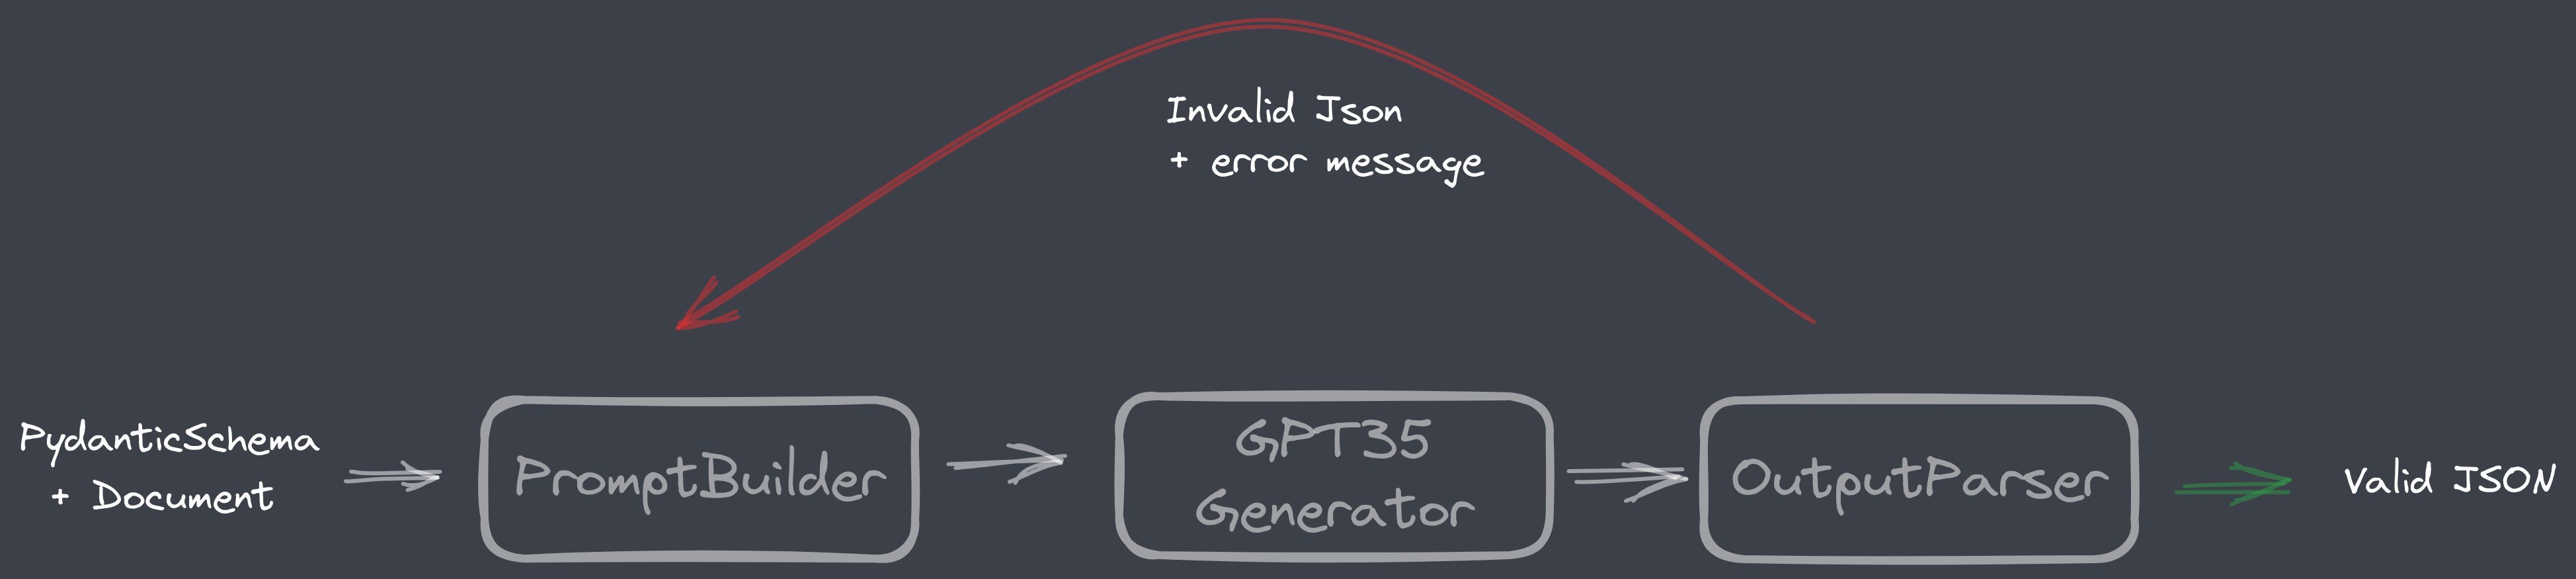


In [13]:
!pip install haystack-ai
!pip install colorama

In [6]:
import getpass
llm_api_key = getpass.getpass("Enter LLM provider api key:")


Enter LLM provider api key:··········


In [34]:
import json
import os

from haystack.preview import Pipeline
from haystack.preview.components.generators.openai import GPTGenerator
from haystack.preview.components.builders.prompt_builder import PromptBuilder
import random
from haystack.preview import component
from typing import Optional, List

import pydantic
from pydantic import BaseModel, ValidationError

import logging
from colorama import Fore

logging.basicConfig()
logging.getLogger("canals.pipeline.pipeline").setLevel(logging.DEBUG)


# Let's define a simple schema for the data we want to extract from a passsage via the LLM
# We want the output from our LLM to be always compliant with this
class City(BaseModel):
    name: str
    country: str
    population: int

class CitiesData(BaseModel):
    cities: List[City]

schema = CitiesData.schema_json(indent=2)


# We then create a simple, custom Haystack component that takes the LLM output
# and validates if this is compliant with our schema.
# If not, it returns also the error message so that we have a better chance of correcting it in the next loop
@component
class OutputParser():
    def __init__(self, pydantic_model:pydantic.BaseModel):
        self.pydantic_model = pydantic_model
        self.iteration_counter = 0

    @component.output_types(valid=List[str],
                            invalid=Optional[List[str]],
                            error_message=Optional[str])
    def run(
            self,
            replies: List[str]):

        self.iteration_counter += 1

        # let's simulate a corrupt JSON with 40% probability by adding extra brackets (for demo purposes)
        if random.randint(0, 100) < 30:
            replies[0] = "{{" + replies[0]

        try:
            output_dict = json.loads(replies[0])
            self.pydantic_model.parse_obj(output_dict)
            print(Fore.GREEN + f"OutputParser at Iteration {self.iteration_counter}: Valid JSON from LLM - No need for looping: {replies[0]}")
            return {"valid": replies}

        except (ValueError, ValidationError) as e:
            print(Fore.RED + f"OutputParser at Iteration {self.iteration_counter}: Invalid JSON from LLM - Let's try again.\n"
                         f"Output from LLM:\n {replies[0]} \n"
                         f"Error from OutputParser: {e}")
            return {"invalid": replies, "error_message": str(e)}


# Let's create a prompt that always includes the basic instructions for creating our JSON, and optionally, information from any previously failed attempt (corrupt JSON + error message from parsing it).
# The Jinja2 templating language gives us full flexibility here to adjust the prompt dynamically depending on which inputs are available
prompt_template = """
 Create a JSON object from the information present in this passage: {{passage}}.
 Only use information that is present in the passage. Follow this JSON schema, but only return the actual instances without any additional schema definition:"
 {{schema}}
 Make sure your response is a dict and not a list.
 {% if replies and error_message %}
    You already created the following output in a previous attempt: {{replies}}
    However, this doesn't comply with the format requirements from above and triggered this Python exception: {{ error_message}}
    Correct the output and try again. Just return the corrected output without any extra explanations.
  {% endif %}
"""

In [35]:
# Let's build the pipeline
pipeline = Pipeline(max_loops_allowed=5)
pipeline.add_component(instance=PromptBuilder(template=prompt_template), name="prompt_builder")
pipeline.add_component(instance=GPTGenerator(api_key=llm_api_key), name="llm")
pipeline.add_component(instance=OutputParser(pydantic_model=CitiesData), name="output_parser")

pipeline.connect("prompt_builder", "llm")
pipeline.connect("llm", "output_parser")
pipeline.connect("output_parser.invalid", "prompt_builder.replies")
pipeline.connect("output_parser.error_message", "prompt_builder.error_message")

DEBUG:canals.pipeline.pipeline:Adding component 'prompt_builder' (<haystack.preview.components.builders.prompt_builder.PromptBuilder object at 0x7c66aa07cd00>)
DEBUG:canals.pipeline.pipeline:Adding component 'llm' (<haystack.preview.components.generators.openai.GPTGenerator object at 0x7c66aa2fd0f0>)
DEBUG:canals.pipeline.pipeline:Adding component 'output_parser' (<__main__.OutputParser object at 0x7c66aa2fcd60>)
DEBUG:canals.pipeline.pipeline:Connecting 'prompt_builder.prompt' to 'llm.prompt'
DEBUG:canals.pipeline.pipeline:Connecting 'llm.replies' to 'output_parser.replies'
DEBUG:canals.pipeline.pipeline:Connecting 'output_parser.invalid' to 'prompt_builder.replies'
DEBUG:canals.pipeline.pipeline:Connecting 'output_parser.error_message' to 'prompt_builder.error_message'


In [36]:
# Now, let's run our pipeline with an example passage that we want to convert into our JSON format
passage = "Berlin is the capital of Germany. It has a population of 3,850,809"
result = pipeline.run({
    "prompt_builder": {"passage": passage,
                       "schema": schema}
})

print(result)

INFO:canals.pipeline.pipeline:Pipeline execution started.
DEBUG:canals.pipeline.pipeline:Mandatory connections:
 - llm: prompt_builder.prompt (str) --> (str) llm.prompt
 - output_parser: llm.replies (List[str]) --> (List[str]) output_parser.replies
 - prompt_builder: output_parser.invalid (Optional[List[str]]) --> (Any) prompt_builder.replies, output_parser.error_message (Optional[str]) --> (Any) prompt_builder.error_message
DEBUG:canals.pipeline.pipeline:> Queue at step 1: prompt_builder []
DEBUG:canals.pipeline.pipeline:Component 'prompt_builder' is ready to run. A variadic input parameter received all the expected values.
INFO:canals.pipeline.pipeline:* Running prompt_builder
DEBUG:canals.pipeline.pipeline:   'prompt_builder' inputs: {'passage': 'Berlin is the capital of Germany. It has a population of 3,850,809', 'schema': '{\n  "title": "CitiesData",\n  "type": "object",\n  "properties": {\n    "cities": {\n      "title": "Cities",\n      "type": "array",\n      "items": {\n      

OutputParser at Iteration 1: Invalid JSON from LLM - Let's try again.
Output from LLM:
 {{{
  "title": "CitiesData",
  "type": "object",
  "properties": {
    "cities": {
      "title": "Cities",
      "type": "array",
      "items": {
        "$ref": "#/definitions/City"
      }
    }
  },
  "required": [
    "cities"
  ],
  "definitions": {
    "City": {
      "title": "City",
      "type": "object",
      "properties": {
        "name": {
          "title": "Name",
          "type": "string"
        },
        "country": {
          "title": "Country",
          "type": "string"
        },
        "population": {
          "title": "Population",
          "type": "integer"
        }
      },
      "required": [
        "name",
        "country",
        "population"
      ]
    }
  }
}

# JSON object from the information in the passage
{
  "cities": [
    {
      "name": "Berlin",
      "country": "Germany",
      "population": 3850809
    }
  ]
} 
Error from OutputParser: Expecting

DEBUG:canals.pipeline.pipeline:   'llm' outputs: {'replies': ['{\n  "cities": [\n    {\n      "name": "Berlin",\n      "country": "Germany",\n      "population": 3850809\n    }\n  ]\n}'], 'metadata': [{'model': 'gpt-3.5-turbo-0613', 'index': 0, 'finish_reason': 'stop', 'usage': {'prompt_tokens': 440, 'completion_tokens': 36, 'total_tokens': 476}}]}

DEBUG:canals.pipeline.pipeline:> Queue at step 6: output_parser []
DEBUG:canals.pipeline.pipeline:Component 'output_parser' is ready to run. All mandatory values were received.
INFO:canals.pipeline.pipeline:* Running output_parser
DEBUG:canals.pipeline.pipeline:   'output_parser' inputs: {'replies': ['{\n  "cities": [\n    {\n      "name": "Berlin",\n      "country": "Germany",\n      "population": 3850809\n    }\n  ]\n}']}
DEBUG:canals.pipeline.pipeline:   'output_parser' outputs: {'valid': ['{\n  "cities": [\n    {\n      "name": "Berlin",\n      "country": "Germany",\n      "population": 3850809\n    }\n  ]\n}']}

INFO:canals.pipeline.pi

OutputParser at Iteration 2: Valid JSON from LLM - No need for looping: {
  "cities": [
    {
      "name": "Berlin",
      "country": "Germany",
      "population": 3850809
    }
  ]
}
{'llm': {'metadata': [{'model': 'gpt-3.5-turbo-0613', 'index': 0, 'finish_reason': 'stop', 'usage': {'prompt_tokens': 440, 'completion_tokens': 36, 'total_tokens': 476}}]}, 'output_parser': {'valid': ['{\n  "cities": [\n    {\n      "name": "Berlin",\n      "country": "Germany",\n      "population": 3850809\n    }\n  ]\n}']}}
